# 3ro Entregable del Reto
## Evaluación y Refinamiento de modelo

#### Carga de librerías

In [146]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from scipy.stats import uniform


#### Importación de base de datos limpia 
Separación de features de label, estandarización de datos y división de datos entre Train set y Test set para su entrenamiento.

In [147]:
df= pd.read_csv('Titanic_train_test.csv')

Separación de datos entre Train(Entrenamiento) y Test(Prueba)

In [148]:
df=df.drop(columns='Unnamed: 0')

In [149]:
dftrain=df.iloc[:891]
dftest=df.iloc[891:]

In [150]:
dftest=dftest.drop(columns=['Survived'])

Separación de features y target

In [151]:
y=dftrain['Survived']
X=dftrain.drop(columns='Survived')

Escalar los features

In [152]:
scaler=StandardScaler()
Xf=scaler.fit_transform(X)

Separación de los datos en train y test 

In [135]:
X_train, X_test, y_train, y_test = train_test_split(Xf, y, test_size=0.2, random_state=42)

### Grid Search
Creación de Grid search para encontrar los mejores parámetros para el algoritmo Random 

In [9]:
def gridSearch(clf_model, param_grid, name):

    # Define the feature selector
    rfecv_model = RFECV(estimator=clf_model, step=1, cv=StratifiedKFold(5), scoring='roc_auc')

    # Creación de pipeline con el modelo de Random Forest y el selector de features
    pipeline = Pipeline([
        ('feature_selection', rfecv_model),
        ('classification', clf_model)
        ])
    
    # Define the GridSearchCV
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=StratifiedKFold(10), scoring='roc_auc_ovr', n_jobs=-1)

    # Hacerle fit model
    grid_search.fit(X_train, y_train)

    # Get the best parameters and score
    print("Best parameters found for ",name,":", grid_search.best_params_)
    print("Best cross-validation score for ",name,":", grid_search.best_score_)
    

#### Random Forest

In [28]:
# Define the classifier
clf_rf = RandomForestClassifier(random_state=42, class_weight="balanced")


param_grid_rf = {
    'classification__n_estimators': [ 5, 10, 50, 200, 250],
    'classification__max_features': ['sqrt','log2'],
    'classification__max_depth': [4, 6, 8, 10, 12],
    'classification__criterion':['gini','log_loss','entropy'],
    'classification__max_leaf_nodes':[2, 5, 10]
}

gridSearch(clf_rf, param_grid_rf, name = "Random Forest" )

Best parameters found for  Random Forest : {'classification__criterion': 'gini', 'classification__max_depth': 10, 'classification__max_features': 'sqrt', 'classification__max_leaf_nodes': 10, 'classification__n_estimators': 200}
Best cross-validation score for  Random Forest : 0.8513247863247864


### Randomized Search

#### Random Forest

In [25]:
clf_rf = RandomForestClassifier(random_state=42, class_weight="balanced")

rfc_search_space = {
    'n_estimators': range(200, 1600),
    'criterion':['gini','log_loss','entropy'],
    'max_depth': range(2, 51),
    'min_samples_split': range(2, 11),
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(estimator=clf_rf, param_distributions=rfc_search_space, n_iter=200, cv=5)
random_search.fit(X_train, y_train)

best_params = random_search.best_params_
rfc = RandomForestClassifier(**best_params)
print(best_params)

rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


{'n_estimators': 1209, 'min_samples_split': 6, 'max_features': 'sqrt', 'max_depth': 4, 'criterion': 'gini', 'bootstrap': True}
Accuracy: 0.8044692737430168


### Manual Tunning

#### Random Forest

In [263]:
#Usando los parámetros de Grid Search
rfc1 = RandomForestClassifier(
    
    max_features = 'sqrt', 
    criterion ='gini',
    max_depth = 10, 
    max_leaf_nodes = 10, 
    n_estimators =  200
)
manual_tunning(rfc1)

Accuracy: 0.8044692737430168
F1 Score: 0.7482014388489209
ROC-AUC: 0.7894465894465894
Confusion Matrix:
[[92 13]
 [22 52]]


In [262]:
#Usando los parámetros de Random Search
rfc2 = RandomForestClassifier(
    
    n_estimators = 1209,
    min_samples_split =6, 
    max_features= 'sqrt', 
    max_depth= 4, 
    criterion= 'gini',
    bootstrap= True
)
manual_tunning(rfc2)

Accuracy: 0.8044692737430168
F1 Score: 0.7482014388489209
ROC-AUC: 0.7894465894465894
Confusion Matrix:
[[92 13]
 [22 52]]


In [261]:
#Usando los parámetros de forma manual y de experimentación
rfc3 = RandomForestClassifier(
    
    max_features = 'sqrt',
    criterion = 'gini',
    n_estimators=200, 
    max_depth=10, 
    min_samples_split=10, 
    random_state=30
)
manual_tunning(rfc3)

Accuracy: 0.8324022346368715
F1 Score: 0.782608695652174
ROC-AUC: 0.8172458172458174
Confusion Matrix:
[[95 10]
 [20 54]]


In [236]:

def manual_tunning(rfc):
    rfc.fit(X_train, y_train)

    y_predRF = rfc.predict(X_test)
    accuracy = accuracy_score(y_test, y_predRF)
    f1 = f1_score(y_test, y_predRF)
    roc_auc = roc_auc_score(y_test, y_predRF)
    conf_matrix = confusion_matrix(y_test, y_predRF)

    print(f'Accuracy: {accuracy}')
    print(f'F1 Score: {f1}')
    print(f'ROC-AUC: {roc_auc}')
    print('Confusion Matrix:')
    print(conf_matrix)

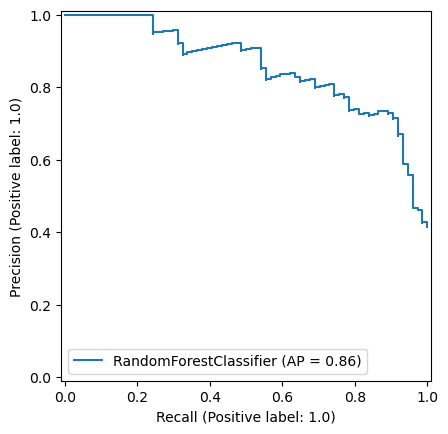

In [16]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_estimator(rfc, X_test, y_test)

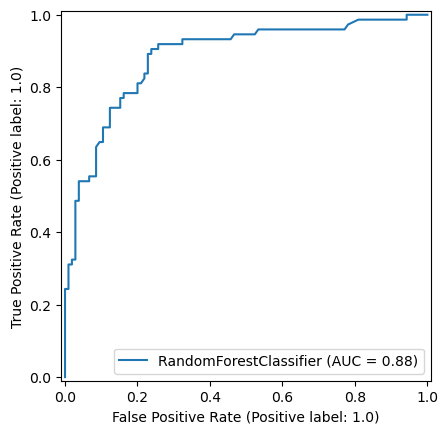

In [14]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(rfc, X_test, y_test)

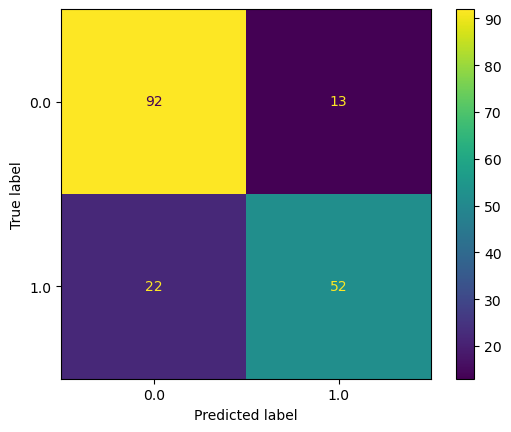

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(rfc, X_test, y_test)